# Time-Based Algorithm: blind SQL injection vulnerability detection

In this notebook, I consider the problem of blind SQL injection vulnerability detection using a custom time-based algorithm. Specifically, making mutiple requests (half with a high sleep delay and the other half with a low sleep delay) to the url being tested and comparing their RTTs to decide whether the url is vulnerable (label 1) or safe (label 0)

**Optimization:** The goal is optimize the algorithm for speed and accuracy. More speficically, it needs to have a true positive rate of less than 0.0001 (1 in 10,000) and a sleep delay that returns a RTT of less than 10 seconds on average

Import libraries

In [209]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
import csv
import seaborn as sns
sns.set()
from statsmodels.distributions.empirical_distribution import ECDF
%matplotlib inline

# Part (a): Data Exploration

1. Collect RTTS of safe and vulnerable URLs and save them into CSV files.

2. Compare the safe and vulnerable RTTs by visualizing them and comparing their mean (as well as other metrics).


**1. Collect RTTS of vulnerable and safe urls**

In [210]:
def collect_rtts(page_type = 'safe', n_pages = 100, sleep_delay = 0):
    '''
    Collects RTTS from URLs and saves them into CSV file
    '''
    
    if sleep_delay != 0:
        query = 'SLEEP({})'.format(sleep_delay)
        file_name = '{}_{}_{}.csv'.format(page_type, n_page, sleep_delay)
    
    else:
        query = '1'
        file_name = '{}_{}.csv'.format(page_type, n_pages)
    
    with open(file_name, 'w') as file:
        writer = csv.writer(file, delimiter=',', lineterminator='\n')
        writer.writerow(['URL', 'RTT'])
        for i in range(1, n_pages+1):
            url = 'http://localhost:5000/{}/{}/page?id={}'.format(page_type, page_num, query)
            response = requests.get(url)
            row = [url, response.elapsed.total_seconds()]
            writer.writerow(row)

In [211]:
# Read data
safe_df = pd.read_csv('Data/safe_100.csv')
vul_df = pd.read_csv('Data/vulnerable_100.csv')
vul_delay_df = pd.read_csv('Data/vulnerable_100_1.csv') # 1 second sleep delay injected

In [212]:
safe_df.head()

,URL,RTT
0,http://localhost:5000/safe/1/page?id=1,6.554458
1,http://localhost:5000/safe/2/page?id=1,3.299523
2,http://localhost:5000/safe/3/page?id=1,2.255223
3,http://localhost:5000/safe/4/page?id=1,2.725735
4,http://localhost:5000/safe/5/page?id=1,4.646487


**2. Compare the RTTs and try to find a trend.**

In [213]:
print('Safe url statistics')
safe_df.describe()

Safe url statistics


,RTT
count,100.000000
mean,3.199542
std,1.691694
min,0.446409
25%,2.014172
50%,2.885159
75%,3.881203
max,10.794784


In [214]:
print('Vulnerable url with delay statistics')
vul_delay_df.describe()

Vulnerable url with delay statistics


,RTT
count,100.000000
mean,8.141448
std,2.086598
min,5.724981
25%,6.786474
50%,7.486104
75%,8.908915
max,17.916236


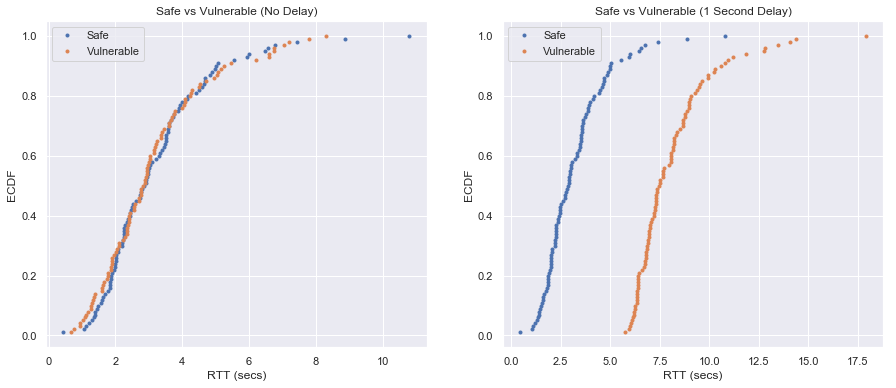

In [227]:
# Calculating CDFs
safe_ecdf = ECDF(safe_df['RTT'])
vul_ecdf = ECDF(vul_df['RTT'])
vul_delay_ecdf = ECDF(vul_delay_df['RTT']) 

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
#fig.tight_layout()

ax[0].plot(safe_ecdf.x, safe_ecdf.y, marker='.', linestyle='none')
ax[0].plot(vul_ecdf.x, vul_ecdf.y, marker='.', linestyle='none')

ax[1].plot(safe_ecdf.x, safe_ecdf.y, marker='.', linestyle='none')
ax[1].plot(vul_delay_ecdf.x, vul_ecdf.y, marker='.', linestyle='none')

ax[0].set_title('Safe vs Vulnerable (No Delay)')
ax[0].legend(('Safe', 'Vulnerable'), loc='best')
ax[0].set_xlabel('RTT (secs)')
ax[0].set_ylabel('ECDF')

_ = ax[1].set_title('Safe vs Vulnerable (1 Second Delay)')
_ = ax[1].legend(('Safe', 'Vulnerable'), loc='best')
_ = ax[1].set_xlabel('RTT (secs)')
_ = ax[1].set_ylabel('ECDF')

In [216]:
print('The mean of the safe URL without a sleep injection is: {}'.format(np.mean(safe_df['RTT'])))

The mean of the safe URL without a sleep injection is: 3.1995424299999997


In [217]:
print('The mean of the vulnerable URL with 1 second sleep injection: {}'.format(np.mean(vul_delay_df['RTT'])))

The mean of the vulnerable URL with 1 second sleep injection: 8.141448309999998


**Observation:** As suspected, without a sleep delay injected, both safe and vulnerable urls have a similar distribution of RTTs. On the other hand, adding a sleep delay of 1 second to the vulnerables urls increseases their delays by about 5 seconds. Also, in some cases, there seems to be an overlap of RTTs between safe urls and vulnerable urls with a 1 second sleep injection. This could be avoided by increasing the sleep delay of the vulnerable url. 

## Part (b): Time-based Algorithm

Since the RTT of a safe url can sometimes overlap with the RTT of a vulnerable url with a 1 second delay, it can be challenging to distinguish between the two without introducing false positives or making the elapsed time of the request too long. 

In order to combat this issue, one can collect the RTTs of two types of requests and compare them to each other in order to find a noticible difference.

In order to have a consistent measure of the RTT differences when. to make them more comparable than if we had collected them in sequential order

1. Collect data of pairs of RTTs with high and low sleep delay

In [218]:
pairs_df = pd.read_csv('Data/dataset_pairs_50_1_0.05.csv')
pairs_high = pairs_df[pairs_df['High Delay'] == 1]
pairs_low = pairs_df[pairs_df['High Delay'] == 0]

In [219]:
pairs_df.head()

,URL,High Delay,RTT
0,http://localhost:5000/vulnerable/1/page?id=SLE...,0,3.579312
1,http://localhost:5000/vulnerable/1/page?id=SLE...,1,7.351426
2,http://localhost:5000/vulnerable/1/page?id=SLE...,0,2.721237
3,http://localhost:5000/vulnerable/1/page?id=SLE...,1,10.874254
4,http://localhost:5000/vulnerable/1/page?id=SLE...,0,2.934227


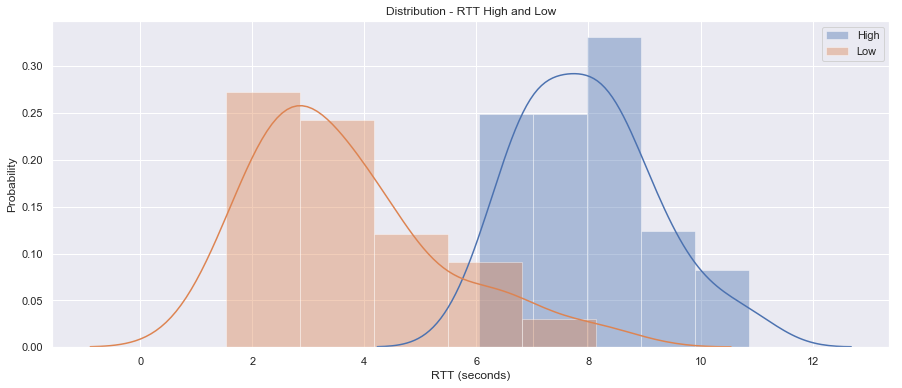

In [236]:
# Calculating CDFs
pairs_high_ecdf = ECDF(pairs_high['RTT']) 
pairs_low_ecdf = ECDF(pairs_low['RTT']) 

plt.figure(figsize=(15, 6))
sns.distplot(pairs_high['RTT'])
sns.distplot(pairs_low['RTT'])

_ = plt.xlabel("RTT (seconds)")
_ = plt.ylabel('Probability')
_ = plt.legend(('High', 'Low'), loc='best')
_ = plt.title('Distribution - RTT High and Low')

In [237]:
print('The median of the high delay is: {}'.format(np.median(pairs_high['RTT'])))
print('The median of the low delay is: {}'.format(np.median(pairs_low['RTT'])))

The median of the high delay is: 7.978613814
The median of the low delay is: 3.1059598669999997


## Part (c) Evaluating Results

In [84]:
safe_test_df = pd.read_csv('Data/safe_results_10500_0.8_0.03_24_3.csv')
vul_test_df = pd.read_csv('Data/vulnerable_results_10500_0.8_0.03_24_3.csv')

In [85]:
safe_test_df.head()

,Test Result
0,0
1,0
2,0
3,0
4,0


In [86]:
# Get False Positive Rate (FPR)
fpr = float(np.sum(safe_test_df['Test Result'])/safe_test_df.shape[0])
print('The False Positive Rate is: {}'.format(fpr))


# Get False Negative Rate (FNR)
fnr = float(vul_test_df[vul_test_df['Test Result'] == 0].count()/vul_test_df.shape[0])
print('The False Negative Rate is: {}'.format(fnr))

The False Positive Rate is: 0.0
The False Negative Rate is: 0.09342857142857143
